# MO436A Project1: Reinforced learning algorithms evaluation

# 1. Problem description 

**Motivation** 

Model an agent to operate in a trading environment. 

**Objectve** 

The agent objective is to maximize the gain. 


# 2. Environments 

## 2.1 Stocrastic

The trading problem is pretty stocrastic, so, to simplify the model, the prices are simulated with simplified version of the Geometric Brownian motion.

This is an example of pricing data generated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mean_return = -0.01  # average hourly return (negative = downward trend)
volatility = 0.03     # standard deviation of returns (3% volatility)

def generate_intraday_prices(num_days=100, hours_per_day=10, start_price=10):
    prices = []
    for _ in range(num_days):
        dt = 1 / hours_per_day 
        drift = (mean_return - 0.5 * volatility**2) * dt
        shock = np.random.normal(loc=0, scale=volatility * np.sqrt(dt), size=hours_per_day)
        #returns = np.random.normal(loc=mean_return, scale=volatility, size=hours_per_day)
        returns = drift + shock
        day_prices = start_price * np.exp(np.cumsum(returns))
        prices.append(day_prices)
    plot_prices(np.array(prices), num_days)
    return np.array(prices)


def plot_prices(prices, num_days):
    # ----- Cálculo da variação diária -----
    # Variação absoluta (fechamento - abertura) e percentual
    open_prices = prices[:, 0]
    close_prices = prices[:, -1]
    daily_abs_change = close_prices - open_prices
    daily_pct_change = (close_prices / open_prices - 1) * 100

    # ----- Figura: Variação do preço por dia (percentual) -----
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar(np.arange(1, num_days+1), daily_pct_change, color=['#2ca02c' if x>=0 else '#d62728' for x in daily_pct_change], width=0.8)

    ax.set_title('Variação percentual diária do preço (fechamento vs. abertura)')
    ax.set_xlabel('Dia')
    ax.set_ylabel('Variação (%)')

    # Linha na horizontal em 0%
    ax.axhline(0, color='black', linewidth=1)

    # Melhores rótulos no eixo x (marcar a cada 5 dias)
    ax.set_xticks(np.arange(1, num_days+1, 5))

    # Texto com estatísticas básicas
    mean_change = np.mean(daily_pct_change)
    std_change = np.std(daily_pct_change)
    ax.text(0.99, 0.02, f'Média: {mean_change:.2f}%\nDesvio-padrão: {std_change:.2f}%', transform=ax.transAxes,
            ha='right', va='bottom', bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

    plt.tight_layout()
    output_file = 'variacao_diaria_percentual.png'
    plt.savefig(output_file, dpi=220)

    # Também salvar a série de variação absoluta (opcional, segunda figura)
    fig2, ax2 = plt.subplots(figsize=(3, 3))
    ax2.plot(np.arange(1, num_days+1), daily_abs_change, marker='o', linewidth=1.5, color='#1f77b4')
    ax2.set_title('Variação absoluta diária do preço (fechamento - abertura)')
    ax2.set_xlabel('Dia')
    ax2.set_ylabel('Δ Preço')
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_xticks(np.arange(1, num_days+1, 5))
    plt.tight_layout()
    output_file2 = 'variacao_diaria_absoluta.png'
    plt.savefig(output_file2, dpi=220)


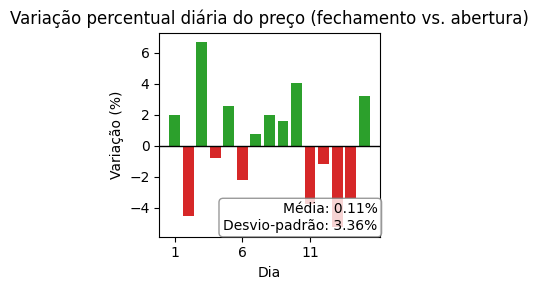

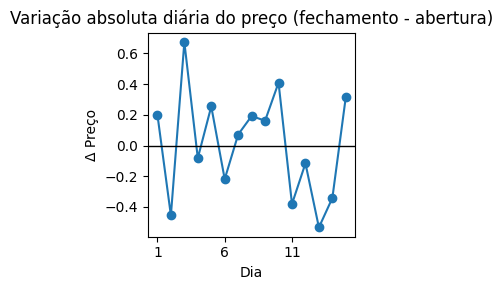

In [2]:
prices = generate_intraday_prices(num_days=15, hours_per_day=10, start_price=10)

With this simulated price, it is possible to define the environment. The gymnasium framework was used to build the ambient.

In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, data, window_size=3):
        super(TradingEnv, self).__init__()
        self.data = data  # dados no formato (dias, horas)
        self.num_days, self.hours_per_day = data.shape
        self.window_size = window_size
        self.current_day = 0
        self.current_step = window_size
        self.initial_cash = 100
        self.cash = self.initial_cash
        self.shares = 0
        self.position = 0
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size + 1,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        self.current_day = np.random.randint(0, self.num_days)  # escolhe um dia aleatório
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.shares = 0
        self.position = 0
        return self._get_obs(), {}

    def step(self, action):
        price = self.data[self.current_day, self.current_step]
        if action == 1 and self.position <= 0:  # comprar
            self.shares = self.cash / price
            self.cash = 0
            self.position = 1
        elif action == 2 and self.position >= 0:  # vender
            self.cash = self.shares * price
            self.shares = 0
            self.position = -1

        portfolio_value = self.cash + self.shares * price
        reward = portfolio_value - self.initial_cash
        obs = self._get_obs()
        self.current_step += 1
        done = self.current_step >= self.hours_per_day  # fim do dia
        return obs, reward, done, False, {}

    def _get_obs(self):
        window = self.data[self.current_day, self.current_step - self.window_size:self.current_step]
        return np.append(window, self.position).astype(np.float32)
    def render(self, mode="human"):
        step_index = min(self.current_step - 1, self.hours_per_day - 1)
        price = self.data[self.current_day, step_index]
        portfolio_value = self.cash + self.shares * price 
        print(f"Step {self.current_step}: Price={price:.2f}, Cash={self.cash:.2f}, Shares={self.shares:.4f}, Portfolio={portfolio_value:.2f}")

In [4]:
env = TradingEnv(prices)
state, _ = env.reset()
env.current_step = 0
env.render()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    if done:
        break
    env.render()

Step 0: Price=9.85, Cash=100.00, Shares=0.0000, Portfolio=100.00
Step 1: Price=9.93, Cash=0.00, Shares=10.0678, Portfolio=100.00
Step 2: Price=9.93, Cash=0.00, Shares=10.0678, Portfolio=100.00
Step 3: Price=9.99, Cash=0.00, Shares=10.0678, Portfolio=100.56
Step 4: Price=10.04, Cash=0.00, Shares=10.0678, Portfolio=101.11
Step 5: Price=10.10, Cash=101.65, Shares=0.0000, Portfolio=101.65
Step 6: Price=9.95, Cash=101.65, Shares=0.0000, Portfolio=101.65
Step 7: Price=9.88, Cash=101.65, Shares=0.0000, Portfolio=101.65
Step 8: Price=9.93, Cash=101.65, Shares=0.0000, Portfolio=101.65
Step 9: Price=9.88, Cash=0.00, Shares=10.2888, Portfolio=101.65


The following code shows the environement initialization and the result of taking 10 random steps

## 2.2 Deterministic environment

In this case, the deterministic events means the system might know, given the current price of the stock, what will be the price of the stock in the next hour (next step). The The Rulkov Map is used to generate price movements deterministically, since it can create a "caotic" price evolution, mantaining. 


In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class DeterministicTradingEnv(gym.Env):
    """
    Deterministic trading environment using the Rulkov Map for price generation.
    
    The Rulkov Map is a chaotic dynamical system that generates deterministic,
    reproducible price movements without randomness.
    """
    
    metadata = {"render_modes": ["human"]}

    def __init__(self, n_steps=10, start_price=10.0,
                 alpha=4.0, beta=10.0, sigma=0.01, mu=0.001,
                 window_size=3):
        """
        Initialize the deterministic trading environment.
        
        Args:
            n_steps: Number of steps per episode (trading hours)
            start_price: Initial asset price
            alpha, beta, sigma, mu: Rulkov Map parameters
            window_size: Number of historical prices to include in observation
        """
        super(DeterministicTradingEnv, self).__init__()
        self.n_steps = n_steps
        self.start_price = start_price
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.mu = mu
        self.window_size = window_size
        self.initial_cash = 100
        self.cash = self.initial_cash

        # Action and observation spaces
        self.action_space = spaces.Discrete(3)  # Hold (0), Buy (1), Sell (2)
        # State: last N prices + cash + asset holdings
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(self.window_size + 2,), dtype=np.float32
        )

        self.reset()

    def f(self, x, y, alpha):
        """Rulkov Map function."""
        if x <= 0:
            return alpha / (1 - x) + y
        elif 0 < x < (alpha + y):
            return alpha + y
        else:
            return -1

    def rulkov_map(self, x, y):
        """Update state using Rulkov Map dynamics."""
        x_next = self.f(x, y + self.beta, self.alpha)
        y_next = y - self.mu * (x_next + 1) + self.mu * self.sigma
        return x_next, y_next

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        super().reset(seed=seed)
        self.x = -1.0
        self.y = -3.5
        self.t = 0
        self.cash = self.initial_cash
        self.asset = 0.0
        self.price = self.start_price
        # Initial price history
        self.price_history = [self.price] * self.window_size
        state = np.array(self.price_history + [self.cash, self.asset], dtype=np.float32)
        return state, {}

    def step(self, action):
        """
        Execute one step in the environment.
        
        Args:
            action: 0 = Hold, 1 = Buy, 2 = Sell
            
        Returns:
            observation, reward, done, truncated, info
        """
        # Update price via Rulkov Map
        self.x, self.y = self.rulkov_map(self.x, self.y)
        self.price *= np.exp(self.x * 0.001)

        # Update price history
        self.price_history.append(self.price)
        if len(self.price_history) > self.window_size:
            self.price_history.pop(0)

        # Execute action
        if action == 1 and self.cash > 0:  # Buy
            self.asset += self.cash / self.price
            self.cash = 0
        elif action == 2 and self.asset > 0:  # Sell
            self.cash += self.asset * self.price
            self.asset = 0

        # Calculate reward: portfolio value change
        portfolio_value = self.cash + self.asset * self.price
        reward = portfolio_value - self.initial_cash

        # Advance time
        self.t += 1
        done = self.t >= self.n_steps

        state = np.array(self.price_history + [self.cash, self.asset], dtype=np.float32)
        return state, reward, done, False, {}

    def render(self, mode="human"):
        """Render the current environment state."""
        print(f"Step {self.t}: Price={self.price:.2f}, Cash={self.cash:.2f}, Asset={self.asset:.2f}")

In [6]:
env = DeterministicTradingEnv()
state, _ = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    env.render()
    if done:
        break

Step 1: Price=10.09, Cash=100.00, Asset=0.00
Step 2: Price=10.19, Cash=100.00, Asset=0.00
Step 3: Price=10.18, Cash=100.00, Asset=0.00
Step 4: Price=10.27, Cash=100.00, Asset=0.00
Step 5: Price=10.38, Cash=100.00, Asset=0.00
Step 6: Price=10.37, Cash=0.00, Asset=9.65
Step 7: Price=10.45, Cash=0.00, Asset=9.65
Step 8: Price=10.56, Cash=0.00, Asset=9.65
Step 9: Price=10.55, Cash=0.00, Asset=9.65
Step 10: Price=10.64, Cash=102.67, Asset=0.00


# 3. MDP Formulation

**States**
 In this problem, the state is defined as: 
 - Current cash
 - Current asset holdings
 - Last window_size prices
The original problem is partially observable, as if only the current price is considered, it is not possible to know if is in an upward or downward trend, so a window_size is needed to make it oberservable.
**Actions**
 The actions in this case are discrete:
- 0 : Hold
- 1 : Buy
- 2 : Sell

**Transactions**
The change of the prices is different on the stocrastic and determinist environments. For the deterministic environment, the prices follows the Rulkov map and for the stocrastic environment, it follows the Geometric Brownian motion. 

**Rewards**

**Terminal Condition**
- Rewards: The reward is defined by profit/loss of each action
- Discount(gamma): long-term gains. 

**Simplfications in the model** 
- The prices are updated hourly and are updated 10 times a day. 
- The prices start with the same value each day.
- The prices std_dev is constant. 
- Here we sell/buy all stocks in portifolium, which means it is the same as considering only one stock.
- Here we don't consider selling only a part of the portifolium. 

**Environment characterists**
- Episodic - As each day is treated as a complete episode. 
- Terminal States - There are not terminal states, but we could set one, for example, choose to stop at a maximum profit or maximum lose. 
- The states are continuous, as they are defined as the price.
- The environment is stocrastic as the price vary ramdonly with a normal distribution.
- This envrionment is partially observable, as we have information of only a window size of prices.


# 4. Monte Carlo

The implementation of Monte Carlo Algorithm can be found here.

In [7]:
import random
import numpy as np
from collections import defaultdict

def discretize_state(state):
    return tuple(np.round(state, 1))

def epsilon_greedy_policy(Q, state, action_space, epsilon):
    if random.random() < epsilon:
        return action_space.sample()
    return np.argmax(Q[state])

def monte_carlo_train(env, num_train_episodes=2000, gamma=0.95, epsilon=0.1, N0=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Q(S,a) = 0
    variable_epsilon = epsilon
    returns = defaultdict(list)
    N_sa = defaultdict(int)
    N_s = defaultdict(int)
    for episode in range(num_train_episodes):
        state, _ = env.reset()
        episode_data = []
        terminated = False

        while not terminated:
            s = discretize_state(state)
            N_s[s] += 1 # update number of visits in this state
            variable_epsilon = N0 / (N0 + N_s[s]) 
            action = epsilon_greedy_policy(Q, s, env.action_space, variable_epsilon)
            next_state, reward, terminated, _, _ = env.step(action)
            episode_data.append((s, action, reward))
            state = next_state

        G = 0
        visited = set()
        for t in reversed(range(len(episode_data))):
            s, a, r = episode_data[t]
            G = gamma * G + r
            if (s, a) not in visited:
                N_sa[(s,a)] += 1
                returns[(s, a)].append(G)
                alpha = 1 / N_sa[(s,a)]
                Q[s][a] += alpha * (G - Q[s][a])
                visited.add((s, a))
    return dict(Q)

## 4.1 Stocrastic environment evaluation

Stocrastic Monte Carlo Training...
Average reward: -1.21 ± 7.80


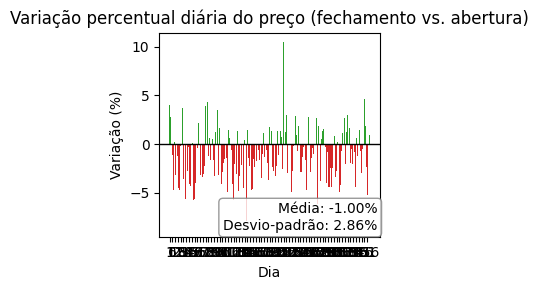

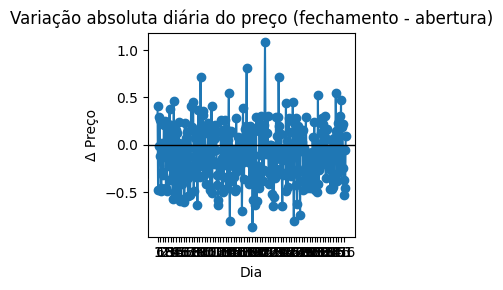

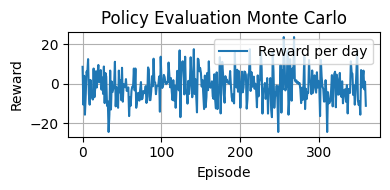

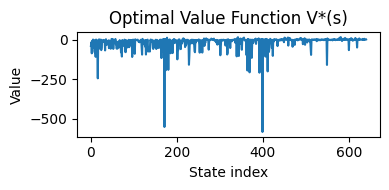

Stocrastic Monte Carlo Training Done


In [8]:
# Hiperparams 
window_size = 3
num_train_episodes = 360*10 #10 years of experience
num_eval_episodes = 360*1 #1 yaar
gamma = 0.99
alpha = 0.05
N0=10
epsilon = 1
hours_per_day = 10
start_price = 10.22
epsilon_decay = 0.0001

#Helper functions to evaluate 
def evaluate(env, Q, num_episodes=100):
    total_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        episode_reward = 0

        while not terminated:
            s = discretize_state(state)
            action = np.argmax(Q[s]) if s in Q else env.action_space.sample()
            next_state, reward, terminated, _, _ = env.step(action)
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)

    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"Average reward: {avg_reward:.2f} ± {std_reward:.2f}")
    return total_rewards


def plot_rewards(rewards):
    plt.figure(figsize=(4, 2))
    plt.plot(rewards, label="Reward per day")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Policy Evaluation Monte Carlo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_values(V):
    plt.figure(figsize=(4, 2))
    plt.plot(list(range(len(V))), list(V.values()))
    plt.title("Optimal Value Function V*(s)")
    plt.xlabel("State index")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()   

def get_value_function(Q):
    V = {}
    for s in Q:
        V[s] = np.max(Q[s])
    return V

prices = generate_intraday_prices(num_eval_episodes, hours_per_day, start_price)
env = TradingEnv(data=prices, window_size=window_size)
print("Stocrastic Monte Carlo Training...")
Q_mc = monte_carlo_train(env, num_train_episodes, gamma, epsilon, N0)
V_mc = get_value_function(Q_mc)
rewards_mc = evaluate(env, Q_mc, num_eval_episodes)
plot_rewards(rewards_mc)
plot_values(V_mc)
print("Stocrastic Monte Carlo Training Done")

## 4.2 Deterministic environment evaluation

Deterministic Monte Carlo Training...
Average reward: 28.05 ± 0.00


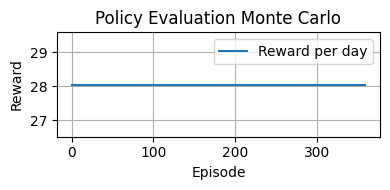

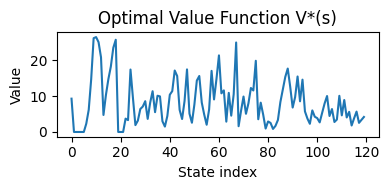

Deterministic Monte Carlo Training Done


In [9]:
det_env = DeterministicTradingEnv(n_steps=hours_per_day, start_price=start_price, window_size=window_size)
print("Deterministic Monte Carlo Training...")
det_Q_mc = monte_carlo_train(det_env, num_train_episodes, gamma, epsilon, N0)
det_V_mc = get_value_function(det_Q_mc)
det_rewards_mc = evaluate(det_env, det_Q_mc, num_eval_episodes)
plot_rewards(det_rewards_mc)
plot_values(det_V_mc)
print("Deterministic Monte Carlo Training Done")

# 5. SARSA

## 5.1 Stocrastic environment evaluation

The implementation of the Sarsa Algorithm can be found here 

In [ ]:
import gymnasium as gym
import numpy as np
import random

env = gym.make("FrozenLake-v1", is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n
Q = np.zeros((n_states, n_actions))
alpha = 0.1      # taxa de aprendizado
gamma = 0.99     # fator de desconto
epsilon = 0.1    # exploração

def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

n_episodes = 1000

for episode in range(n_episodes):
    state = env.reset()[0]
    action = choose_action(state)

    done = False
    while not done:
        next_state, reward, done, _, _ = env.step(action)
        next_action = choose_action(next_state)

        # Atualização SARSA
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

        state = next_state
        action = next_action
total_rewards = 0
for _ in range(100):
    state = env.reset()[0]
    done = False
    while not done:
        action = np.argmax(Q[state])
        state, reward, done, _, _ = env.step(action)
        total_rewards += reward

print("Average return:", total_rewards / 100)

In [ ]:
    print("Stocrastic Q-Learning Training...")
    Q_ql, rewards_ql = q_learning_train(env, num_train_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=0.2)
    V_ql = get_value_function(Q_ql)
    rewards_ql = evaluate(env, Q_ql, num_eval_episodes)
    plot_rewards(rewards_ql, filename="QLearning_rewards_stochastic.png")
    plot_values(V_ql, filename="QLearning_ValueFunction.png")

# 6.Q-Learning

# 7. Linear Function Approximator**

# 8. DQN